
# Sports filed registration

In [1]:
import os

import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm

from utils import utils, warp, image_utils, constant_var
from models import end_2_end_optimization
from options import fake_options
import cv2

In [8]:
import sys

sys.path.insert(1, '/home/chrizandr')

from yolov3.annotations.annot.annot_utils import CVAT_Track, CVAT_annotation
import pickle

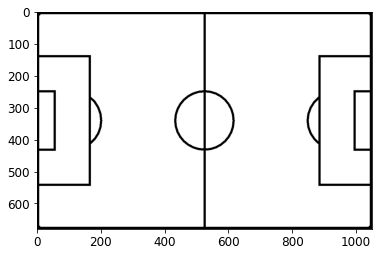

In [49]:
template_image = imageio.imread("data/template2.png", pilmode='RGB')
template_image = template_image / 255.0

template_image.shape
temp = np.array(template_image)
plt.imshow(temp)

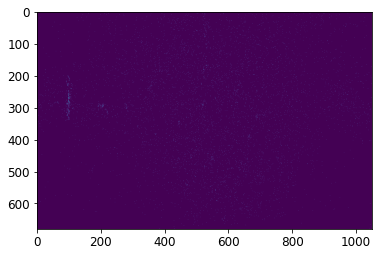

In [116]:
hmap = pickle.load(open("heatmap_envscr.pkl", "rb"))


plt.imshow(hmap)

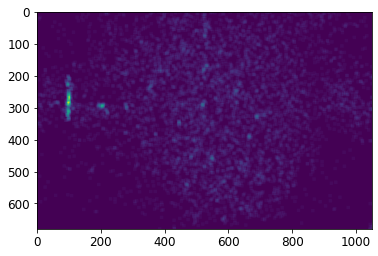

In [117]:
kernel = np.ones((11, 11),np.float32)
dst = cv2.filter2D(hmap,-1,kernel)

plt.imshow(dst)

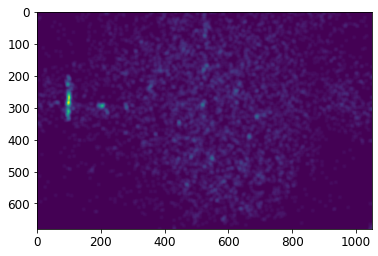

In [118]:
blur = cv2.GaussianBlur(dst,(11,11),0)
plt.imshow(blur)

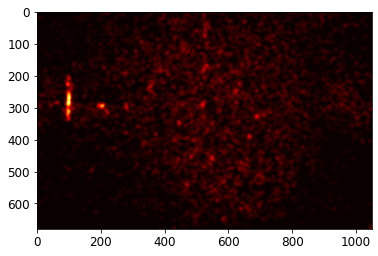

In [119]:
cmap = plt.get_cmap('hot')

out = cmap(blur / blur.max())
out = np.delete(out, 3,2)
plt.imshow(out)

In [120]:
mask = np.ones(out.shape)
mask[np.where(out==[1, 1, 1])] = 0

In [121]:
np.where((1-temp)==1)

(array([  0,   0,   0, ..., 679, 679, 679]),
 array([   0,    0,    0, ..., 1049, 1049, 1049]),
 array([0, 1, 2, ..., 0, 1, 2]))

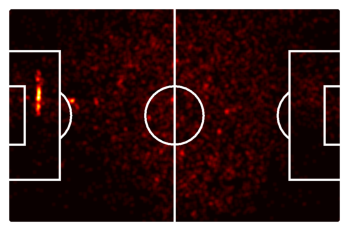

In [122]:
plt.imshow(out * (temp) + (1-temp))
plt.axis('off')
plt.savefig('hmapenvscr.png', dpi=300, bbox_inches='tight', transparent="True", pad_inches=0)

In [123]:
# set some options
opt = fake_options.FakeOptions()
opt.batch_size = 1
opt.coord_conv_template = True
opt.error_model = 'loss_surface'
opt.error_target = 'iou_whole'
opt.goal_image_path = './data/world_cup_2018.png'
opt.guess_model = 'init_guess'
opt.homo_param_method = 'deep_homography'
opt.load_weights_error_model = 'pretrained_loss_surface'
opt.load_weights_upstream = 'pretrained_init_guess'
opt.lr_optim = 1e-5
opt.need_single_image_normalization = True
opt.need_spectral_norm_error_model = True
opt.need_spectral_norm_upstream = False
opt.optim_criterion = 'l1loss'
opt.optim_iters = 200
opt.optim_method = 'stn'
opt.optim_type = 'adam'
opt.out_dir = './out'
opt.prevent_neg = 'sigmoid'
opt.template_path = './data/world_cup_template.png'
opt.warp_dim = 8
opt.warp_type = 'homography'

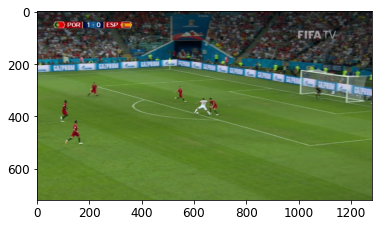

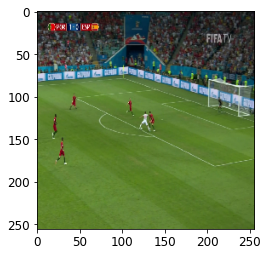

mean of goal image: -1.1641532182693481e-09
std of goal image: 0.9999948740005493


In [124]:
# read original image
goal_image = imageio.imread(opt.goal_image_path, pilmode='RGB')
plt.imshow(goal_image)
plt.show()
# resize image to square shape, 256 * 256, and squash to [0, 1]
pil_image = Image.fromarray(np.uint8(goal_image))
pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
goal_image = np.array(pil_image)
plt.imshow(goal_image)
plt.show()
# covert np image to torch image, and do normalization
goal_image = utils.np_img_to_torch_img(goal_image)
if opt.need_single_image_normalization:
    goal_image = image_utils.normalize_single_image(goal_image)
print('mean of goal image: {0}'.format(goal_image.mean()))
print('std of goal image: {0}'.format(goal_image.std()))

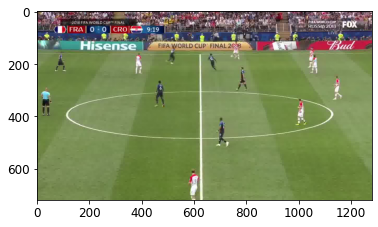

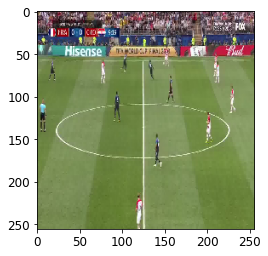

mean of goal image: -1.785034897672233e-09
std of goal image: 0.9999948740005493


In [125]:
# read original image

img_name = "test.jpg"
goal_image = imageio.imread(img_name, pilmode='RGB')
plt.imshow(goal_image)
plt.show()
# resize image to square shape, 256 * 256, and squash to [0, 1]
pil_image = Image.fromarray(np.uint8(goal_image))
pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
goal_image = np.array(pil_image)
plt.imshow(goal_image)
plt.show()
# covert np image to torch image, and do normalization
goal_image = utils.np_img_to_torch_img(goal_image)
if opt.need_single_image_normalization:
    goal_image = image_utils.normalize_single_image(goal_image)
print('mean of goal image: {0}'.format(goal_image.mean()))
print('std of goal image: {0}'.format(goal_image.std()))

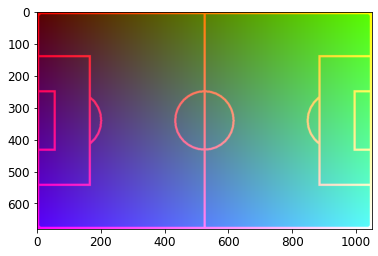

mean of template: -8.970059184321144e-08
std of template: 0.9999995231628418


(680, 1050)

In [126]:
# read template image
template_image = imageio.imread(opt.template_path, pilmode='RGB')
template_image = template_image / 255.0
if opt.coord_conv_template:
    template_image = image_utils.rgb_template_to_coord_conv_template(template_image)
plt.imshow(template_image)
plt.show()
# covert np image to torch image, and do normalization
template_image = utils.np_img_to_torch_img(template_image)
if opt.need_single_image_normalization:
    template_image = image_utils.normalize_single_image(template_image)
print('mean of template: {0}'.format(template_image.mean()))
print('std of template: {0}'.format(template_image.std()))

np.zeros(template_image.shape[1::]).shape


In [127]:
e2e = end_2_end_optimization.End2EndOptimFactory.get_end_2_end_optimization_model(opt)

---------------------- NOTIFICATION ----------------------

Resnet backbone config for loss_surface
Spectral norm for resnet: True
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for loss_surface
From: ./out/pretrained_loss_surface/checkpoint.pth.tar

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Resnet backbone config for init_guess
Spectral norm for resnet: False
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


In [128]:
orig_homography, optim_homography = e2e.optim(goal_image[None], template_image)

---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  0%|          | 0/200 [00:00<?, ?it/s]/home/chrizandr/mmd/lib/python3.7/site-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


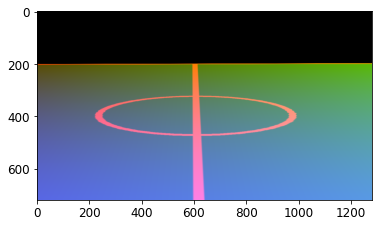

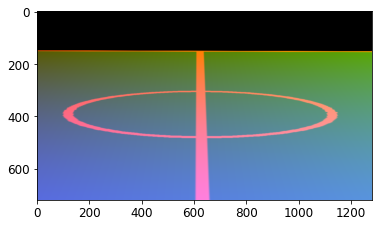

In [132]:
# reload image and template for visualization
# overload goal image
goal_image_draw = imageio.imread("test.jpg", pilmode='RGB')
goal_image_draw = goal_image_draw / 255.0
outshape = goal_image_draw.shape[0:2]

# overload template image
template_image_draw = imageio.imread(opt.template_path, pilmode='RGB')
template_image_draw = template_image_draw / 255.0
template_image_draw = image_utils.rgb_template_to_coord_conv_template(template_image_draw)
template_image_draw = utils.np_img_to_torch_img(template_image_draw)

# warp template image with initial guess
warped_tmp_orig = warp.warp_image(template_image_draw, orig_homography, out_shape=outshape)[0]
warped_tmp_orig = utils.torch_img_to_np_img(warped_tmp_orig)
plt.imshow(warped_tmp_orig)
plt.show()

# warp template image with optimized guess
warped_tmp_optim = warp.warp_image(template_image_draw, optim_homography, out_shape=outshape)[0]
warped_tmp_optim = utils.torch_img_to_np_img(warped_tmp_optim)
plt.imshow(warped_tmp_optim)
plt.show()

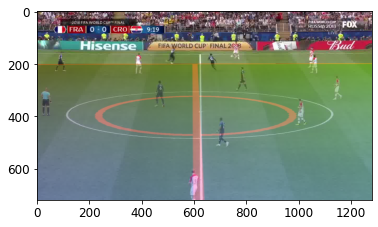

In [133]:
# show initial guess overlay
show_image = np.copy(goal_image_draw)
valid_index = warped_tmp_orig[:, :, 0] > 0.0
overlay = (goal_image_draw[valid_index].astype('float32') + warped_tmp_orig[valid_index].astype('float32'))/2
show_image[valid_index] = overlay
plt.imshow(show_image)
plt.show()

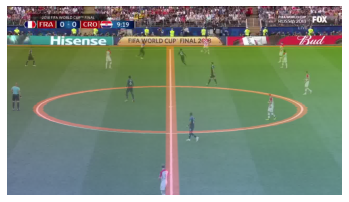

In [140]:
# show optimized guess overlay
show_image = np.copy(goal_image_draw)
valid_index = warped_tmp_optim[:, :, 0] > 0.0
overlay = (goal_image_draw[valid_index].astype('float32') + warped_tmp_optim[valid_index].astype('float32'))/2
show_image[valid_index] = overlay
plt.imshow(show_image)
plt.axis('off')
plt.savefig('mapped.png', dpi=300, bbox_inches='tight', transparent="True", pad_inches=0)

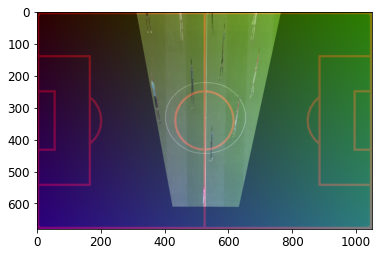

In [135]:
# show original top-down view
H_inv = torch.inverse(orig_homography)
outshape = template_image_draw.shape[1:3]
warped_frm = warp.warp_image(utils.np_img_to_torch_img(goal_image_draw)[None], H_inv, out_shape=outshape)[0]
plt.imshow(utils.torch_img_to_np_img(warped_frm)*0.5+utils.torch_img_to_np_img(template_image_draw)*0.5)
plt.show()

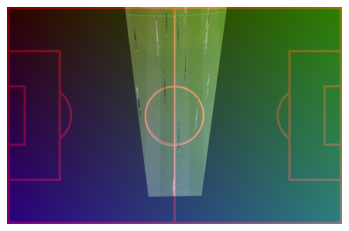

In [139]:
# show optimized top-down view
H_inv = torch.inverse(optim_homography)
outshape = template_image_draw.shape[1:3]
warped_frm = warp.warp_image(utils.np_img_to_torch_img(goal_image_draw)[None], H_inv, out_shape=outshape)[0]
plt.imshow(utils.torch_img_to_np_img(warped_frm)*0.5+utils.torch_img_to_np_img(template_image_draw)*0.5)
plt.axis('off')
plt.savefig('warped.png', dpi=300, bbox_inches='tight', transparent="True", pad_inches=0)

In [137]:
imgs = os.listdir("/ssd_scratch/cvit/chrizandr/images")
total_imgs = len(imgs)

frames = [int(x.strip("image").strip(".jpg")) for x in imgs]
frames.sort()
assert frames == [x for x in range(1, total_imgs+1)]
sampled_imgs = [x for x in range(1, total_imgs+1, 60)]
len(sampled_imgs)

FileNotFoundError: [Errno 2] No such file or directory: '/ssd_scratch/cvit/chrizandr/images'

torch.Size([3, 680, 1050])


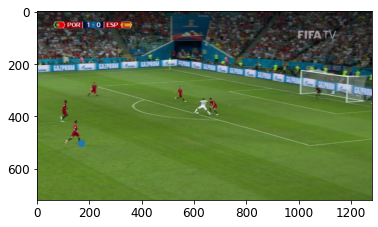

tensor([-0.36953,  0.19861,  1.00000])
451.9292928278446 450.7308918237686


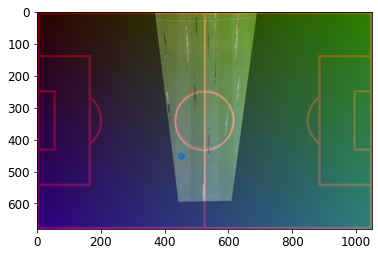

In [138]:
# warp a point from frame to template
print(template_image.shape)
frame_point = np.array([167, 503])
plt.imshow( imageio.imread(opt.goal_image_path, pilmode='RGB'))
plt.scatter(frame_point[0], frame_point[1])
plt.show()

x = torch.tensor(frame_point[0] / 1280 - 0.5).float()
y = torch.tensor(frame_point[1] / 720 - 0.5).float()
xy = torch.stack([x, y, torch.ones_like(x)])
print(xy)
xy_warped = torch.matmul(optim_homography.cpu(), xy)  # H.bmm(xy)
xy_warped, z_warped = xy_warped.split(2, dim=1)

# we multiply by 2, since our homographies map to
# coordinates in the range [-0.5, 0.5] (the ones in our GT datasets)
xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
x_warped, y_warped = torch.unbind(xy_warped, dim=1)
# [-1, 1] -> [0, 1]
x_warped = (x_warped.item() * 0.5 + 0.5) * 1050
y_warped = (y_warped.item() * 0.5 + 0.5) * 680
print(x_warped, y_warped)
plt.imshow(utils.torch_img_to_np_img(warped_frm)*0.5+utils.torch_img_to_np_img(template_image_draw)*0.5)
plt.scatter(x_warped, y_warped)
plt.show()

The optimized result is more aligned with the input frame than initial guess. Our methods trained on only 170 images from World Cup 2014, and can successfully generalize to games from different time, stadium, and camera pose.

In [141]:
import seaborn as sns
import cv2
import pickle

heatmap = pickle.load(open("heatmap.pkl", "rb"))
heatmap = heatmap / heatmap.max()
mask = (heatmap == 0).astype(int)



In [155]:
import matplotlib 
matplotlib.rcParams['figure.figsize'] = [10, 10]

cmask_red = np.array([165, 0, 0]).reshape(1, 1, 3) * (1 - mask.reshape(mask.shape[0], mask.shape[1], 1))
cmask_red = cmask_red.astype(np.uint8)

cmask_white = np.array([255, 255, 0]).reshape(1, 1, 3) * mask.reshape(mask.shape[0], mask.shape[1], 1)
cmask_white = cmask_white.astype(np.uint8)
cmask_red.shape
# plt.imshow(cmask_red + cmask_white)
# plt.show()

(680, 1050, 3)

In [152]:
cmask_red * heatmap.reshape(heatmap.shape[0], heatmap.shape[1], 1)
np.unique(cmask_red)

array([          0,         165])

### Apply to video

In [11]:
opt.optim_iters = 80

In [12]:
video_cap = cv2.VideoCapture('./data/sample.mp4')
frame_list = []
while True:
    success, image = video_cap.read()
    if not success:
        break
    pil_image = Image.fromarray(np.uint8(image[..., ::-1]))
    pil_image = pil_image.resize([1280, 720], resample=Image.NEAREST)
    image = np.array(pil_image)
    frame_list.append(image)

In [13]:
orig_homography_list = []
for idx, frame in enumerate(frame_list):
    pil_image = Image.fromarray(np.uint8(frame))
    pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
    frame = np.array(pil_image)
    frame = utils.np_img_to_torch_img(frame)
    if opt.need_single_image_normalization:
        frame = image_utils.normalize_single_image(frame)
    orig_homography = e2e.homography_inference.infer_upstream_homography(frame[None])
    orig_homography_list.append(orig_homography.detach())

In [14]:
first_frame = True
optim_homography_list = []
for idx, frame in enumerate(frame_list):
    print('{0} / {1}'.format(idx+1, len(frame_list)))
    pil_image = Image.fromarray(np.uint8(frame))
    pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
    frame = np.array(pil_image)
    frame = utils.np_img_to_torch_img(frame)
    if opt.need_single_image_normalization:
        frame = image_utils.normalize_single_image(frame)
    _, optim_homography = e2e.optim(frame[None], template_image, refresh=first_frame)
    optim_homography_list.append(optim_homography.detach())
    first_frame = False

  4%|▍         | 3/80 [00:00<00:03, 22.00it/s]

1 / 91
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  4%|▍         | 3/80 [00:00<00:03, 21.71it/s]

2 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.85it/s]

3 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.77it/s]

4 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.21it/s]

5 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.21it/s]

6 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.48it/s]

7 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.31it/s]

8 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.59it/s]

9 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.64it/s]

10 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.36it/s]

11 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.77it/s]

12 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.30it/s]

13 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.28it/s]

14 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.98it/s]

15 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.12it/s]

16 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.19it/s]

17 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.64it/s]

18 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.13it/s]

19 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.17it/s]

20 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.90it/s]

21 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.30it/s]

22 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.89it/s]

23 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.37it/s]

24 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.34it/s]

25 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.13it/s]

26 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.57it/s]

27 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.73it/s]

28 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.46it/s]

29 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.47it/s]

30 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.41it/s]

31 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.14it/s]

32 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.89it/s]

33 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.37it/s]

34 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.09it/s]

35 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.87it/s]

36 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.97it/s]

37 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.54it/s]

38 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.17it/s]

39 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.79it/s]

40 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.28it/s]

41 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.25it/s]

42 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.62it/s]

43 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.03it/s]

44 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.39it/s]

45 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.43it/s]

46 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.76it/s]

47 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.55it/s]

48 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.90it/s]

49 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.34it/s]

50 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.81it/s]

51 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.41it/s]

52 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.62it/s]

53 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.77it/s]

54 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.35it/s]

55 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.68it/s]

56 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.26it/s]

57 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.86it/s]

58 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.59it/s]

59 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.19it/s]

60 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.15it/s]

61 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.11it/s]

62 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.49it/s]

63 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.97it/s]

64 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.34it/s]

65 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.39it/s]

66 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.88it/s]

67 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.66it/s]

68 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.16it/s]

69 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.55it/s]

70 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.42it/s]

71 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.16it/s]

72 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.25it/s]

73 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.53it/s]

74 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.22it/s]

75 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.91it/s]

76 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.99it/s]

77 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.57it/s]

78 / 91


  4%|▍         | 3/80 [00:00<00:03, 21.93it/s]

79 / 91


  4%|▍         | 3/80 [00:00<00:03, 20.59it/s]

80 / 91


  4%|▍         | 3/80 [00:00<00:03, 23.01it/s]

81 / 91


  4%|▍         | 3/80 [00:00<00:03, 23.26it/s]

82 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.93it/s]

83 / 91


  4%|▍         | 3/80 [00:00<00:03, 23.28it/s]

84 / 91


  4%|▍         | 3/80 [00:00<00:03, 23.12it/s]

85 / 91


  4%|▍         | 3/80 [00:00<00:03, 23.32it/s]

86 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.74it/s]

87 / 91


  4%|▍         | 3/80 [00:00<00:03, 23.21it/s]

88 / 91


  4%|▍         | 3/80 [00:00<00:03, 23.03it/s]

89 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.99it/s]

90 / 91


  4%|▍         | 3/80 [00:00<00:03, 22.29it/s]

91 / 91


100%|██████████| 80/80 [00:03<00:00, 22.37it/s]


In [15]:
warped_tmp_orig_list = []
warped_tmp_optim_list = []
for orig_h, optim_h in zip(orig_homography_list, optim_homography_list):
    warped_tmp_orig = warp.warp_image(template_image_draw, orig_h, out_shape=(720, 1280))[0]
    warped_tmp_orig = utils.torch_img_to_np_img(warped_tmp_orig)
    warped_tmp_orig_list.append(warped_tmp_orig)
    warped_tmp_optim = warp.warp_image(template_image_draw, optim_h, out_shape=(720, 1280))[0]
    warped_tmp_optim = utils.torch_img_to_np_img(warped_tmp_optim)
    warped_tmp_optim_list.append(warped_tmp_optim)

In [16]:
def save_to_vid(frame_list, template_list, fname):
    video_name = fname
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('M','J','P','G'), 25, (1280, 720))
    edge_color = [0, 1.0, 0]
    for frame, template in zip(frame_list, template_list):
        video_content = frame[..., ::-1] / 255.0
        template_content = template
        valid_index = template_content[..., 0]>0
        edge_index = template_content[..., 0] >= 254.0/255.0
        overlay = (video_content[valid_index].astype('float32') + template_content[valid_index].astype('float32'))/2
        out_frame = video_content.copy()
        out_frame[valid_index] = overlay
        out_frame[edge_index] = edge_color
        out_frame = out_frame * 255.0
        out_frame = out_frame.astype('uint8')
        video.write(out_frame)
    cv2.destroyAllWindows()
    video.release()
    os.system("/usr/bin/ffmpeg -y -i {0} -vcodec libx264 {1}".format(fname, fname.replace('.mp4', '_h264.mp4')))

save_to_vid(frame_list, warped_tmp_orig_list, './video_out/orig_overlay.mp4')
save_to_vid(frame_list, warped_tmp_optim_list, './video_out/optim_overlay.mp4')

In [17]:
if not os.path.isfile('./video_out/orig_overlay_h264.mp4') or not os.path.isfile('./video_out/optim_overlay_h264.mp4'):
    assert 0, 'Converting from MJPEG to H264 failed, please manually check the output in ./video_out'

In [18]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="./video_out/orig_overlay_h264.mp4" type="video/mp4">
</video></div>

In [19]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="./video_out/optim_overlay_h264.mp4" type="video/mp4">
</video></div>